In [1]:
import gym
from gym import spaces
from itertools import permutations 
import numpy as np
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt

In [2]:
from collections import namedtuple
from itertools import count
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [157]:
class TSPDQEnv(gym.Env):
  def __init__(self, dist_matrix):
    # number of vertices
    self.N = len(dist_matrix)
    self.action_space = spaces.Discrete(self.N*self.N)
    self.dist_matrix = dist_matrix

    # flattend adjacency matrix
    self.observation_space = self.N * self.N

    # index to edge
    self.index_edge = {}

    index = 0
    for i in range(self.N):
      for j in range(self.N):
        self.index_edge[index] = (i, j)
        index += 1

    self.reset()
  
  def feature_adj(self, state):
    # convert flattend adjacency matrix to adjacency list
    adj_list = dict()
    for i in range(self.N):
      adj_list[i] = []
    
    matrix = state.reshape(self.N, self.N)

    for j in range(self.N):
      for k in range(self.N):
        if matrix[j][k] == 1:
          adj_list[j].append(k)


    return adj_list
  
  def sanity_check(self, adj_list):

    # It can not form a single cycle or it has self cycle
    for i in range(len(adj_list)):
      if len(adj_list[i]) > 2:
        return 0
      elif i in adj_list[i]:
        return 0

    return 1

  def cycle_check(self, adj_list):
    # check whether there is a cycle in this graph, if yes, whether it's a TSP.

    visited = [0] * self.N

    count = 0
    cycle = False

    for i in range(self.N):
      if visited[i] == 0:
        cycle = cycle or self.dfs_visit(i, adj_list, visited, -1)
        count += 1
    
    if count > 1 and cycle == True:
      # there is a small cycle
      return 0
    elif count == 1 and cycle == True:
      # all vertices are connected
      return 2
    
    return 1
  
  def dfs_visit(self,i,adj_list,visited, parent):
    visited[i] = 1
    result = False

    for j in adj_list[i]:
      if j!= parent and visited[j] == 1:
        return True

      if j!= parent and visited[j] == 0:
        result = result or self.dfs_visit(j, adj_list, visited, i)

    return result
  
  def step(self, action):

    next_state = self.S.copy()
    # edge already exists
    if next_state[action] == 1:
      return self.S, -100000, False, {}
    else:
      next_state[action] = 1
      edge = self.index_edge[action]

      # opposite edge
      next_state[edge[1]*self.N+edge[0]] = 1
      adj_list = self.feature_adj(next_state)
      # if some vertices have degrees greater than 2, it cannot form a single cycle.
      if self.sanity_check(adj_list) == 0:
        return self.S, -100000, False, {}
      else:
        cycle = self.cycle_check(adj_list)
        # if there is a small cycle
        if cycle == 0:
          return self.S, -100000,False, {}
        # if TSP
        elif cycle == 2:
          reward = -self.dist_matrix[edge[0]][edge[1]]     
          self.S = next_state
          return self.S, reward, True, {}
        else:
          reward = -self.dist_matrix[edge[0]][edge[1]]     
          self.S = next_state 
          return self.S, reward, False, {}
  
  def reset(self):
    self.S = np.zeros(self.observation_space)
    return self.S

In [4]:
dist_matrix = np.ones((5,5))
dist_matrix

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [6]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [129]:
class DQN(nn.Module):
    def __init__(self, input_size):
        super(DQN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, input_size*30))
        layers.append(nn.ReLU())
        #layers.append(nn.Linear(input_size*30, input_size*10))
        #layers.append(nn.ReLU())
        layers.append(nn.Linear(input_size*30, input_size))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [9]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.

            # Note: input state must be reshaped to (1,-1) if there is only one obs.
            return policy_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(len(state[0]))]], device=device, dtype=torch.long)

In [62]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch. This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    next_state_batch = torch.cat(batch.next_state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)


    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = target_net(next_state_batch).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss.item()


In [89]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [130]:
# Initialization

BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

env = TSPDQEnv(dist_matrix)

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(len(dist_matrix)**2).to(device)
target_net = DQN(len(dist_matrix)**2).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1000)

steps_done = 0

In [131]:
num_episodes = 50
episode_rewards = []
train_loss = []

for i_episode in range(num_episodes):

  # Initialize the environment and state
  state = torch.FloatTensor([env.reset()]).cuda()
  cumulative_reward = 0
  cumulative_loss = []

  while 1:

    loss = None
    # Select and perform an action
    action = select_action(state)
    next_state, reward, done, _ = env.step(action.item())
    cumulative_reward += reward
    reward = torch.FloatTensor([reward]).cuda()
    next_state = torch.FloatTensor([next_state]).cuda()

    assert type(state) == torch.Tensor and type(action) == torch.Tensor and type(next_state) == torch.Tensor and type(reward) == torch.Tensor
    # Store the transition in memory
    memory.push(state, action, next_state, reward)
    # Move to the next state
    state = next_state
    # Perform one step of the optimization (on the target network)
    loss = optimize_model()
    if loss != None:
      cumulative_loss.append(loss)
    if done:
      episode_rewards.append(cumulative_reward)
      train_loss.append(np.mean(cumulative_loss))
      break
  
  
  
  if i_episode % TARGET_UPDATE == 0:
    target_net.load_state_dict(policy_net.state_dict())
    print("Finished ", i_episode+1, "/", num_episodes, " episodes. ", "Rewards: ", episode_rewards[-1], " Loss: ", train_loss[-1])


    


    

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finished  1 / 50  episodes.  Rewards:  -700005.0  Loss:  nan
Finished  11 / 50  episodes.  Rewards:  -5000005.0  Loss:  17196.609499289774
Finished  21 / 50  episodes.  Rewards:  -48000005.0  Loss:  8237.590763681943
Finished  31 / 50  episodes.  Rewards:  -3000005.0  Loss:  4079.738912527902
Finished  41 / 50  episodes.  Rewards:  -4000005.0  Loss:  6163.114925130209


In [132]:
len(memory)

1000

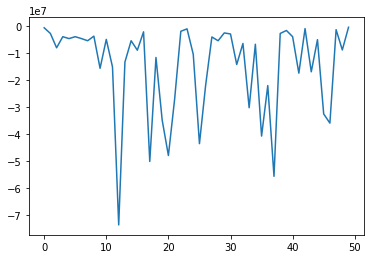

In [133]:
plt.plot(episode_rewards)

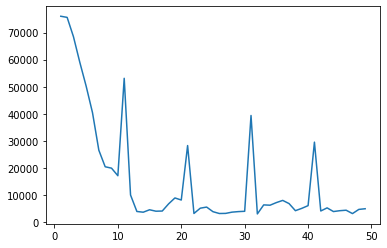

In [134]:
plt.plot(train_loss)

In [135]:
action_list = []
state = torch.FloatTensor([env.reset()]).cuda()
count = 0
while count < 6:
  action = policy_net(state).max(1)[1].view(1,1)
  next_state, reward, done, _ = env.step(action.item())
  action_list.append(action.item())
  next_state = torch.FloatTensor([next_state]).cuda()

  state = next_state
  count+=1
  if done:
    break


In [136]:
action_list

[14, 14, 14, 14, 14, 14]

Discrete(25)

In [140]:
class Agent:
  def __init__(self, env, learning_rate = 5e-4):
    self.env = env
    self.learning_rate = learning_rate
    self.model = DQN(len(dist_matrix)**2)
    self.model = self.model.to(device)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)  

  def predict(self, s):
    return self.model(s)

  def sample_action(self, s, eps):
    if torch.rand(1) < eps:
      return torch.tensor(self.env.action_space.sample())
    else:
      return torch.argmax(self.predict(s))

In [150]:
def make_obs(state):
  return torch.FloatTensor(state).to(device)

def play_one_round(env, agent, eps, gamma, loss_fn, scaler = None):
  state = env.reset()
  observation = make_obs(state)
  done = False
  totalreward = 0
  iters = 0
  while not done:
    action = agent.sample_action(observation, eps).detach().cpu().numpy()
    prev_observation = observation
    state, reward, done, info = env.step(action.item())
    observation = make_obs(state)

    with torch.no_grad():
      next_q = agent.predict(observation)
    #The rest is our normal Q-learning
    future_reward = reward + gamma*torch.max(next_q)
    expected_future_reward = agent.predict(prev_observation)[action] 
    loss = loss_fn(future_reward, expected_future_reward)

    # Optimize the model
    agent.optimizer.zero_grad()
    loss.backward()
    for param in agent.model.parameters():
        param.grad.data.clamp_(-1, 1)
    agent.optimizer.step()

    totalreward += reward
    iters += 1

  return totalreward, iters

In [204]:
agent = Agent(env)
gamma = 0.99
loss_fn = nn.MSELoss()

N = 8010
totalrewards = []#np.empty(N)
for n in range(N):
    #5% exploration
    #eps = 0.05
    #Exploration decays
    eps = 1.0/np.sqrt(n+1)
    totalreward, iters = play_one_round(env, agent, eps, gamma, loss_fn)
    totalrewards.append(totalreward)
    #if n% 1 == 0:
    if n % 100 == 0:
      print("episode:", n, "iters", iters, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", np.array(totalrewards[max(0, n-100):(n+1)]).mean())
    # if np.array(totalrewards[max(0, n-100):(n+1)]).mean() >= 200:
    #     break

episode: 0 iters 17 total reward: -1200005.0 eps: 1.0 avg reward (last 100): -1200005.0
episode: 100 iters 21 total reward: -1600005.0 eps: 0.09950371902099892 avg reward (last 100): -1144559.4554455446
episode: 200 iters 16 total reward: -1100005.0 eps: 0.07053456158585983 avg reward (last 100): -1109905.9900990098
episode: 300 iters 21 total reward: -1600005.0 eps: 0.0576390417704235 avg reward (last 100): -1117826.7821782178
episode: 400 iters 13 total reward: -800005.0 eps: 0.04993761694389223 avg reward (last 100): -1235648.5643564356
episode: 500 iters 16 total reward: -1100005.0 eps: 0.04467670516087703 avg reward (last 100): -1424757.4752475247
episode: 600 iters 21 total reward: -1600005.0 eps: 0.04079085082240021 avg reward (last 100): -1590104.0099009902
episode: 700 iters 14 total reward: -900005.0 eps: 0.0377694787300249 avg reward (last 100): -1415846.584158416
episode: 800 iters 21 total reward: -1600005.0 eps: 0.03533326266687867 avg reward (last 100): -1555450.54455445

In [285]:
state = env.reset()
observation = make_obs(state)
a_list = []

In [286]:
action = agent.sample_action(observation, eps).detach().cpu().numpy()
a_list.append(action)
action

array(6)

In [287]:
prev_observation = observation
state, reward, done, info = env.step(action.item())
observation = make_obs(state)

In [278]:
with torch.no_grad():
      next_q = agent.predict(observation)
#The rest is our normal Q-learning
future_reward = reward + gamma*torch.max(next_q)
expected_future_reward = agent.predict(prev_observation)[action] 
loss = loss_fn(future_reward, expected_future_reward)

# Optimize the model
agent.optimizer.zero_grad()
loss.backward()
for param in agent.model.parameters():
    param.grad.data.clamp_(-1, 1)
agent.optimizer.step()

In [244]:
play_one_round(env, agent, eps, gamma, loss_fn)

(-500005.0, 10)

In [216]:
state

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])